In [3]:
from google.colab import files

dataset_gz = files.upload()

Saving nesmdb_midi.tar.gz to nesmdb_midi.tar.gz


In [7]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0CB4-0C01

 Directory of C:\Users\tonyz\Desktop\UMN\FALL_2022\CSCI_5511\Project

12/10/2022  03:51 PM    <DIR>          .
11/11/2022  03:43 PM    <DIR>          ..
12/10/2022  03:51 PM    <DIR>          .ipynb_checkpoints
12/10/2022  03:51 PM         1,455,265 CSCI5511_Final_Project.ipynb
12/09/2022  12:07 PM         3,555,613 music_generation.ipynb
12/09/2022  09:51 PM    <DIR>          nesmdb
04/11/2018  07:43 PM    <DIR>          nesmdb_midi
12/09/2022  12:12 PM        12,922,275 nesmdb_midi.tar.gz
12/07/2022  06:05 PM               144 README.txt
11/26/2022  09:04 PM             3,198 test.ipynb
12/07/2022  04:27 PM    <DIR>          vgm2wav
12/07/2022  04:35 PM    <DIR>          vgmplay
               5 File(s)     17,936,495 bytes
               7 Dir(s)  138,692,091,904 bytes free


In [4]:
# DONT NEED TO RUN FOR LOCAL

!tar -xf nesmdb_midi.tar.gz
# !sudo apt install -y fluidsynth
# !pip install --upgrade pyfluidsynth
!pip install pretty_midi
print("Done")

Done


In [1]:
import collections
import datetime
# import fluidsynth
import glob
import os
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [3]:
data_dir = "nesmdb_midi"
filenames = glob.glob(str(os.path.join(data_dir,'**/*.mid*')))
print('Number of files:', len(filenames))

Number of files: 5278


In [11]:
sample_file = filenames[1]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)

nesmdb_midi\test\002_1943_TheBattleofMidway_01_02PowerUpYourP38.mid


In [ ]:
basename = os.path.basename(sample_file)
print(basename)
noext = os.path.splitext(basename)[0]
print(noext)
outfile = noext + ".wav"
print(outfile)

293_Shinobi_06_07MissionClear.mid
293_Shinobi_06_07MissionClear
293_Shinobi_06_07MissionClear.wav


In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

In [ ]:
!pip install midi2audio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from midi2audio import FluidSynth

# define outfile name
basename = os.path.basename(sample_file)
noext = os.path.splitext(basename)[0]
outfile = noext + ".wav"
print(outfile)

# using the default sound font in 44100 Hz sample rate
fs = FluidSynth()
fs.midi_to_audio(sample_file, outfile)

# # FLAC, a lossless codec, is supported as well (and recommended to be used)
# fs.midi_to_audio('input.mid', 'output.flac')

# create audio playback widget
import IPython.display as ipd
ipd.Audio(outfile) # load a local WAV file

293_Shinobi_06_07MissionClear.wav


In [ ]:
!midiplay sample_file

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Parameter '/root/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.
Parameter 'sample_file' not a SoundFont or MIDI file or error occurred identifying it.
fluidsynth: error: Failed to connect to Jack server.
Failed to create the audio driver


In [ ]:
print('Number of instruments:', len(pm.instruments))
for i in range(len(pm.instruments)):
    instrument = pm.instruments[i]
    instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
    print('Instrument name:', instrument_name)

Number of instruments: 4
Instrument name: Lead 1 (square)
Instrument name: Lead 2 (sawtooth)
Instrument name: Synth Bass 1
Instrument name: Breath Noise


In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=8, note_name=G#-1, duration=0.0665
1: pitch=8, note_name=G#-1, duration=0.0665
2: pitch=8, note_name=G#-1, duration=0.0665
3: pitch=8, note_name=G#-1, duration=0.0665
4: pitch=8, note_name=G#-1, duration=0.0665
5: pitch=8, note_name=G#-1, duration=0.0665
6: pitch=8, note_name=G#-1, duration=0.0665
7: pitch=3, note_name=D#-1, duration=0.0658
8: pitch=3, note_name=D#-1, duration=0.0661
9: pitch=3, note_name=D#-1, duration=0.0661


In [4]:
# Modify for midi files with multiple instruments

# instrument id:
# 0: Lead 1 (square)
# 1: Lead 2 (sawtooth)
# 2: Synth Bass 1
# 3: Breath Noise

# IMPORTANT NOTE:
# I chose to use integer encoding on the instrument number because it's easy, 
# not because I think theres a reason why its better. It is probably worth 
# trying one hot encoding for the instrument as well

def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)

  notes = collections.defaultdict(list)

  # create a list of all notes from all instruments
  all_notes = []
  for i in range(len(pm.instruments)):
    instrument = pm.instruments[i]
    # create a list of tuple that each have both the note object and the intsrument id
    ins_i_notes = [(n, i) for n in instrument.notes]
    all_notes += ins_i_notes

  # Sort all the notes by start time. The final dataframe should have notes from diffrent instruments interspersed with each other
  sorted_notes = sorted(all_notes, key=lambda note: note[0].start)
  prev_start = sorted_notes[0][0].start

  for note in sorted_notes:
    start = note[0].start
    end = note[0].end
    notes['pitch'].append(note[0].pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    notes['instrument'].append(note[1])
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
instrument0 = pm.instruments[0]
notes = collections.defaultdict(list)
print(type(instrument0.notes))
instrument1 = pm.instruments[1]

<class 'list'>


In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes

,pitch,start,end,step,duration,instrument
0,8,0.116689,0.183197,0.000000,0.066508,3
1,8,0.216531,0.283039,0.099841,0.066508,3
2,8,0.316372,0.382880,0.099841,0.066508,3
3,8,0.416236,0.482698,0.099864,0.066463,3
4,8,0.516032,0.582540,0.099796,0.066508,3
5,8,0.615873,0.682381,0.099841,0.066508,3
6,8,0.715714,0.782222,0.099841,0.066508,3
7,3,0.816236,0.882041,0.100522,0.065805,3
8,44,0.816667,0.915578,0.000431,0.098912,2
9,63,0.915351,1.015102,0.098685,0.099751,0


In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#4', 'G#4', 'C#5', 'D#5', 'D#4', 'G#4', 'C#5', 'D#5', 'F#5'],
      dtype='<U3')

In [5]:
color_by_ins = {0: "blue", 1:"#FF33ED", 2:"#FF5733", 3:"black"}
shape_by_ins = {0: "s", 1:"^", 2:".", 3:"x"}

def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])

  plt.figure(figsize=(20, 4))
  for i in range(4):
    ins_i_notes = notes.loc[notes['instrument'] == i]
    plot_i_pitch = np.stack([ins_i_notes['pitch'], ins_i_notes['pitch']], axis=0)
    plot_i_start_stop = np.stack([ins_i_notes['start'], ins_i_notes['end']], axis=0)
    plt.plot(
        plot_i_start_stop[:, :count], plot_i_pitch[:, :count], color=color_by_ins[i], marker=shape_by_ins[i])
    
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [ ]:
plot_piano_roll(raw_notes)

NameError: ignored

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

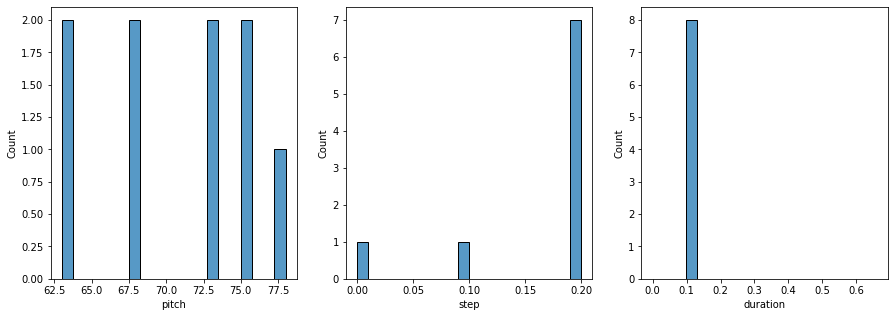

In [ ]:
plot_distributions(raw_notes)

In [ ]:
for x in range(4):
  print(x)

0
1
2
3


nesmdb_midi\train\186_KidIcarus_00_01TitleBGM.mid


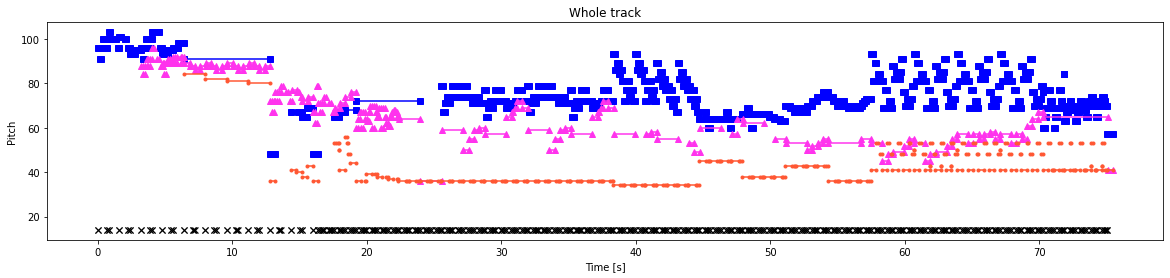

In [6]:
# get sample file
sample_file = filenames[2500]
# sample_file = "nesmdb_midi/valid/402_ZeldanoDensetsu_09_10SaveScreenPrototype.mid"
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

# turn into notes
raw_notes = midi_to_notes(sample_file)

# plot notes
plot_piano_roll(raw_notes)

In [ ]:
# get audio player
display_audio(pm)

# Create the training dataset

In [7]:
# consider turning this into a pickle

import time
start = time.time()
num_files = len(filenames)
print("Num files: {}".format(num_files))
all_notes = []
num_skipped = 0
skipped_files = []
for f in filenames[:num_files]:
  # TODO: add en exception handler here to find files to investigate
  try:
    notes = midi_to_notes(f)
    all_notes.append(notes)
  except (IndexError, ValueError):
    num_skipped += 1
    skipped_files.append(f)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

end = time.time()
elapsed = end-start
print("Elapsed time: {}".format(elapsed))



Num files: 5278
Number of notes parsed: 3152085
Elapsed time: 318.0031838417053


In [21]:
import pickle
pickle_out = open("all_notes.pkl","wb")
pickle.dump(all_notes, pickle_out)
pickle_out.close()

In [23]:
pickle_in = open("all_notes.pkl","rb")
test = pickle.load(pickle_in)

In [24]:
test

,pitch,start,end,step,duration,instrument
0,76,0.000159,0.000181,0.000000,0.000023,0
1,60,0.000181,0.582608,0.000023,0.582426,0
2,13,0.000930,0.067370,0.000748,0.066440,3
3,60,0.004150,0.200000,0.003220,0.195850,2
4,13,0.200590,0.267052,0.196440,0.066463,3
...,...,...,...,...,...,...
21,65,2.196803,2.396485,0.000204,0.199683,1
22,79,2.396281,2.795624,0.199478,0.399342,0
23,67,2.396485,2.795828,0.000204,0.399342,1
24,80,2.795624,3.294671,0.399138,0.499048,0


In [22]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0CB4-0C01

 Directory of C:\Users\tonyz\Desktop\UMN\FALL_2022\CSCI_5511\Project

12/10/2022  10:59 PM    <DIR>          .
11/11/2022  03:43 PM    <DIR>          ..
12/10/2022  03:51 PM    <DIR>          .ipynb_checkpoints
12/10/2022  10:59 PM       151,301,201 all_notes.pkl
12/10/2022  10:59 PM         1,471,958 CSCI5511_Final_Project.ipynb
12/09/2022  12:07 PM         3,555,613 music_generation.ipynb
12/09/2022  09:51 PM    <DIR>          nesmdb
04/11/2018  07:43 PM    <DIR>          nesmdb_midi
12/09/2022  12:12 PM        12,922,275 nesmdb_midi.tar.gz
12/07/2022  06:05 PM               144 README.txt
11/26/2022  09:04 PM             3,198 test.ipynb
12/07/2022  04:27 PM    <DIR>          vgm2wav
12/07/2022  04:35 PM    <DIR>          vgmplay
               6 File(s)    169,254,389 bytes
               7 Dir(s)  128,621,547,520 bytes free


In [16]:
num_skipped

34

In [17]:
all_notes

,pitch,start,end,step,duration,instrument
0,76,0.000159,0.000181,0.000000,0.000023,0
1,60,0.000181,0.582608,0.000023,0.582426,0
2,13,0.000930,0.067370,0.000748,0.066440,3
3,60,0.004150,0.200000,0.003220,0.195850,2
4,13,0.200590,0.267052,0.196440,0.066463,3
...,...,...,...,...,...,...
21,65,2.196803,2.396485,0.000204,0.199683,1
22,79,2.396281,2.795624,0.199478,0.399342,0
23,67,2.396485,2.795828,0.000204,0.399342,1
24,80,2.795624,3.294671,0.399138,0.499048,0


In [8]:
key_order = ['pitch', 'step', 'duration','instrument']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [9]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(4,), dtype=tf.float64, name=None)

In [10]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0, 1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 4), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'instrument': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [12]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 4)
sequence elements (first 10): tf.Tensor(
[[5.93750000e-01 0.00000000e+00 2.26757370e-05 0.00000000e+00]
 [4.68750000e-01 2.26757370e-05 5.82426304e-01 0.00000000e+00]
 [1.01562500e-01 7.48299320e-04 6.64399093e-02 3.00000000e+00]
 [4.68750000e-01 3.21995465e-03 1.95850340e-01 2.00000000e+00]
 [1.01562500e-01 1.96439909e-01 6.64625850e-02 3.00000000e+00]
 [7.34375000e-01 1.99319728e-01 2.26757370e-05 1.00000000e+00]
 [4.29687500e-01 2.26757370e-05 7.82222222e-01 1.00000000e+00]
 [7.34375000e-01 2.49433107e-04 2.26757370e-05 2.00000000e+00]
 [4.29687500e-01 2.26757370e-05 1.99795918e-01 2.00000000e+00]
 [5.93750000e-01 1.98979592e-01 2.26757370e-05 0.00000000e+00]], shape=(10, 4), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=48.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=2.2675736961463855e-05>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=1.580907029478458>, 'instrument': <tf.Tensor: shape=(), dtype=float64, nu

In [13]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [14]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 4), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'instrument': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

# Create and train the model

In [15]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [16]:
input_shape = (seq_length, 4)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
  'instrument': tf.keras.layers.Dense(4, name='instrument')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
      'instrument': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 4)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          68096       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 instrument (Dense)             (None, 4)            516         ['lstm[0][0]']                   
                                                                                              

In [23]:
losses = model.evaluate(train_ds, return_dict=True)
losses

49250/49250 [==============================] - 471s 4ms/step - loss: 7.6527 - duration_loss: 1.3483 - instrument_loss: 1.3995 - pitch_loss: 4.8599 - step_loss: 0.0450


{'loss': 7.652698516845703,
 'duration_loss': 1.3483020067214966,
 'instrument_loss': 1.3994821310043335,
 'pitch_loss': 4.859882831573486,
 'step_loss': 0.04504253715276718}

In [17]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.1,
        'step': 1.0,
        'duration':1.0,
        'instrument':0.5,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

  41326/Unknown - 173s 4ms/step - loss: 2.5773 - duration_loss: 1.3466 - instrument_loss: 1.3995 - pitch_loss: 4.8599 - step_loss: 0.0450

In [18]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [19]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
  36505/Unknown - 23865s 647ms/step - loss: 0.7197 - duration_loss: 0.0588 - instrument_loss: 0.5990 - pitch_loss: 3.5498 - step_loss: 0.0065

KeyboardInterrupt: 

In [ ]:
%%time
epochs = 1

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

   8144/Unknown - 6034s 714ms/step - loss: 0.6360 - duration_loss: 0.0667 - instrument_loss: 0.4662 - pitch_loss: 3.3032 - step_loss: 0.0059

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

NameError: name 'history' is not defined

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
!ls

nesmdb_midi  nesmdb_midi.tar.gz  sample_data
